# Assignment 5: Neural networks

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

# General instructions

1. Do not remove any text or code cells; do not leave redundent print messages.
1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that there are 3 exercises and the last cell in the notebook says **end of assignment**; if you are missing anything please download the origianl file from the course website.
1. Your code should run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, numba, multiprocessig.
1. Questions regarding the exercises should be posted to the course forum at the designated group (i.e. "assignment5"). You can post questions anonymously. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the [course website](https://scicompy.yoavram.com/assignments).

# Cloud computing with GPU

**In Ex 2 and Ex 3 there is a benefit in running on a computer with a GPU. There are two ways to do that:**
1. Use [**Google Colaboratory**](http://colab.research.google.com) (free.) Colaboratory provides free GPU usage for 12 hours inside a Jupyter notebook. Once you are inside colaboratory, upload this notebook, and change the runtime to Python 3 + GPU. Don't forget to download your notebook when you finish (from the File menu), although it will be saved in your Google Docs.

~~1. Use **AWS Educate**. You will recieve an email with instructions on how to redeem your AWS Educate account, an which you will have \$50 credits to use for AWS services. [Instructions are provided](https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/) for setting up a deep learning environment with conda, jupyter, and keras. Note that when you go over the credit limit (\$50) your account will be suspended and you will not have access to your work, so plan accordingly. Some GPU-enabled instances estimated  costs are: p2.xlarge (Tesla K80) 22 USD/day; p3.2xlarge (2 x Tesla v100) 75 USD/day; p3.16xlarge (8 x Tesla v100) 600 USD/day. At this stage you should probably take the cheapest one.`~~

It's can be worth the effort: epochs on the dataset used in Ex 2 and Ex 3 take about 15 secs on colaboratory, compared to 40 secs on my laptop. 
But it is not mandatory to work with a GPU, you can use your local CPU.

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numba
import keras
import scipy.stats
import seaborn as sns
sns.set_context('notebook')

In [1]:
# this code is required for Ex 1
def display_image(im):
    plt.imshow(im.reshape((28, 28)), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    
def fully_connected(ninputs, noutputs):
    boundary = np.sqrt(6 / (ninputs + noutputs))
    return np.random.uniform(-boundary, boundary, size=(ninputs, noutputs))

def softmax(x):
    expx = np.exp(x - x.max(axis=1, keepdims=True))
    return expx / expx.sum(axis=1, keepdims=True)

def accuracy(Yhat, Y):
    return (Y.argmax(axis=1) == Yhat.argmax(axis=1)).mean()

def cross_entropy(Yhat, Y):
    ylogy = Y * np.log(Yhat)
    return -ylogy.sum()

def ReLU(X):
    return np.maximum(X, 0)

def dReLU(X):
    return (X > 0).astype(float)

def drop(X, keep_prob=1):
    if keep_prob < 1:
        X = X.copy() # we don't want to change X
        keeps = np.random.rand(X.shape[1]) < keep_prob
        # X.shape is (nsamples, nfeatures)
        X[:, ~keeps] = 0 # ignore
        X[:, keeps] *= (1/keep_prob) # normalize
    return X

def predict(Ws, X):
    if X.ndim == 1:
        X = X.reshape((1, -1))
    return feed_forward(Ws, X, keep_prob=1)[-1]

def display_prediction(idx):
    prediction = predict(Ws, X_test[idx, :]).argmax()
    print(prediction)
    return display_image(X_test[idx])

def loss(Ws, X, Y):
    Yhat = predict(Ws, X)
    return cross_entropy(Yhat, Y)

def gradient_check(Ws, X, Y, Δ=1e-5):
    dWs = back_propagation(Ws, X, Y, keep_prob=1)
    Ws_ = [W.copy() for W in Ws]

    for i, (W_, dW_) in enumerate(zip(Ws_, dWs)):
        print('W{}'.format(i+1))
        for i in range(W_.shape[0]):
            for j in range(W_.shape[1]):
                dw = dW_[i, j]
                W_[i,j] += Δ
                loss1 = loss(Ws_, X, Y)
                W_[i,j] -= 2*Δ
                loss2 = loss(Ws_, X, Y)
                W_[i,j] += Δ
                dw_ = (loss1 - loss2) / (2 * Δ)
                rel_error = abs(dw - dw_) / abs(dw + dw_)
                if not np.isclose(dw_, dw):
                    print(i, j, dw, dw_, rel_error)
                    
def average(prev, curr, β):
    return [
        β * p + (1 - β) * c
        for p, c
        in zip(prev, curr)
    ]
    
class AdamOptimizer:
    def __init__(self, α=0.001, β1=0.9, β2=0.999, ϵ=1e-8):
        self.α = α
        self.β1 = β1
        self.β2 = β2
        self.ϵ = ϵ
        self.m = None
        self.v = None
        self.t = 0

    def send(self, gradients):
        if self.m is None:
            self.m = [0] * len(gradients)
        if self.v is None:
            self.v = [0] * len(gradients)

        self.t += 1
        αt = self.α * np.sqrt(1 - self.β2**self.t) / (1 - self.β1**self.t)
        self.m = average(self.m, gradients, self.β1)        
        self.v = average(self.v, (g*g for g in gradients), self.β2)

        updates = [-αt * mi / (np.sqrt(vi) + self.ϵ) for mi, vi in zip(self.m, self.v)]
        for upd in updates:
            assert np.isfinite(upd).all()
        return updates
    
def trainer(Ws, X, Y, optimizer, batch_size=50, keep_prob=1):    
    nsamples = X.shape[0]
    batch = 0
    while True:
        # get next batch
        start = (batch * batch_size) % nsamples
        stop = start + batch_size
        batch_idx = range(start, stop)
        X_, Y_ = X[batch_idx, :], Y[batch_idx, :]
        
        gradients = back_propagation(Ws, X_, Y_, keep_prob=keep_prob) # calculate gradients
        
        ΔWs = optimizer.send(gradients) # calculate updates
        
        for W, ΔW in zip(Ws, ΔWs): # apply updates
            W += ΔW
            
        batch += 1
        yield batch

# Ex 1

Let's load the data for MNIST digits.

In [3]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train.reshape(nsamples, nfeatures)
X_test = X_test.reshape(-1, nfeatures)
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

**Implement `feed_forward` and `back_propagation` from the FFN lecture using a `for` loop so that they work for any number of hidden layers.**

Notes: 
- when implementing `back_propagation`, you can use the `gradient_check` function (from `A5.py`) to test that it works as expected.
- please keep the functions signatures as supplied.

In [44]:
def feed_forward(Ws, X, keep_prob=1): ###
    # your code here
    return layers ###

In [45]:
def back_propagation(Ws, X, Y, keep_prob=1): ###
    # your code here

    # sanity checks ###
    assert len(gradients) == len(Ws), (len(gradients), len(Ws)) ###
    for dW, W in zip(gradients, Ws): ###
        assert dW.shape == W.shape, (dW.shape, W.shape) ###
    return gradients ###

Now **train the FFN model** with 2 or more hidden layers, and print its accuracy on the test set.

In [46]:
# create model here

In [47]:
acc = accuracy(predict(Ws, X_test), Y_test) ###
print("Accuracy: {:.4f}".format(acc)) ###

Accuracy: 0.1008


In [48]:
# train model here

acc = accuracy(predict(Ws, X_test), Y_test) ###
print("Accuracy ({:d}): {:.4f}".format(batch, acc)) ###

Accuracy (12000): 0.9492


# Ex 2

The Fashion-MNIST dataset contains 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST. The class labels are:


| Label |	Description|
|---|------------------|
| 0 |	T-shirt/top    |
| 1 |	Trouser        |
| 2 |	Pullover       |
| 3 |	Dress          |
| 4 |	Coat           |
| 5 |	Sandal         |
| 6 |	Shirt          |
| 7 |	Sneaker        |
| 8 |	Bag            |
| 9 |	Ankle boot     |

See [keras docs](https://keras.io/datasets/).

In this exercise we will train a CNN on the dataset. 

We'll get the data via [`keras.datasets`](https://keras.io/datasets/).

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import keras
print('Keras', keras.__version__)
from keras import backend as K
print('GPU:', K.tensorflow_backend._get_available_gpus())

Keras 2.2.4
GPU: []


In [53]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() ###

We need to convert the images to a float32 between 0 and 1 and reshape to 28x28x1 (only one channel for black and white) because 2D convolutions expect 3D images (3rd dimension is channel or image).

We also need to one-hot encode the labels.

In [54]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Let's see the images.

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


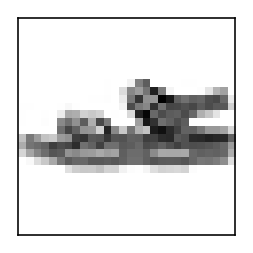

In [55]:
i = np.random.randint(0, x_train.shape[0])
plt.figure(figsize=(2,2))
plt.imshow(x_train[i, :, :, 0], cmap='gray_r')
plt.xticks([]); plt.yticks([])
print(y_train[i])

**Build, train, and score a CNN**.

When I trained a CNN I got this accuracy of ~87% on the test set, see if you can top that.
However, I was not successful using Adam optimizer, but rather changed to RMSprop optimizer with `lr=0.0001` and `decay=1e-6` as recommended somewhere online.

In [19]:
# create Keras CNN model here

In [ ]:
# compile model here

In [20]:
# train model here

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 34s 566us/step - loss: 0.8884 - acc: 0.6866 - val_loss: 0.5663 - val_acc: 0.7917
Epoch 2/10
60000/60000 [==============================] - 43s 714us/step - loss: 0.5645 - acc: 0.7933 - val_loss: 0.4875 - val_acc: 0.8217
Epoch 3/10
60000/60000 [==============================] - 34s 566us/step - loss: 0.5012 - acc: 0.8174 - val_loss: 0.4446 - val_acc: 0.8383
Epoch 4/10
60000/60000 [==============================] - 34s 560us/step - loss: 0.4622 - acc: 0.8321 - val_loss: 0.4243 - val_acc: 0.8452
Epoch 5/10
60000/60000 [==============================] - 35s 577us/step - loss: 0.4352 - acc: 0.8428 - val_loss: 0.3969 - val_acc: 0.8579
Epoch 6/10
60000/60000 [==============================] - 37s 616us/step - loss: 0.4148 - acc: 0.8502 - val_loss: 0.3822 - val_acc: 0.8646
Epoch 7/10
60000/60000 [==============================] - 37s 624us/step - loss: 0.3986 - acc: 0.8569 - val_loss: 0.

In [34]:
# Score trained model
loss, acc = model.evaluate(x_test, y_test, verbose=1) ###
print('Test loss:', loss) ###
print('Test accuracy:', acc) ###

10000/10000 [==============================] - 2s 157us/step
Test loss: 0.34512671473026274
Test accuracy: 0.877


# Ex 3


Next, we'll use the model we trained on MNIST digits (in the lecture) to fit the MNIST-fashion dataset that we just worked on.
This is a case of *transfer learning*, in which we transfer knowledge gained on one problem to solve another problem.

**Load the model** we trained on MNIST digits dataset in the lecture using `keras.models.load_model`.
Don't worry about the warning that Keras failed to load the optimizer state, as we don't care about the optimizer state.

Note: this will fail if you haven't saved the model during the lecture.
If you are using colaboratory or AWS, you will need to figure out how to upload the saved model from the lecture to the cloud.
Maybe just copy the code from the lecture, then run and save. Or put the model .h5 file in dropbox, get a share link, and download it to colaboratory/AWS using a notebook cell with a `!wget url` command. Then change the h5 filepath below.

In [88]:
model = # load model here
model.summary() ###

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               102500    
__________

/Users/yoavram/miniconda3/envs/SciComPy/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


We re-init the last layer (the output layer, the softmax layer), since we have the exact same shape for the output.
However, similar approach can be used to replace the layer completely with a different layer.

In [83]:
last_layer = model.get_layer(index=-1) ###
last_layer.kernel.initializer.run(session=K.get_session()) ###

**Compile the model**.

In [84]:
# compile model here

**Retrain the model on the fashion data**, but only for 5 epochs.

Note: the digits data used a different shape than the fashion data, and therefore the digits model started with a reshape layer.

In [85]:
# train model here

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 50s 832us/step - loss: 0.5492 - acc: 0.8081 - val_loss: 0.3453 - val_acc: 0.8738
Epoch 2/5
60000/60000 [==============================] - 52s 874us/step - loss: 0.3465 - acc: 0.8766 - val_loss: 0.3105 - val_acc: 0.8881
Epoch 3/5
60000/60000 [==============================] - 51s 852us/step - loss: 0.2977 - acc: 0.8944 - val_loss: 0.2930 - val_acc: 0.8961
Epoch 4/5
60000/60000 [==============================] - 52s 867us/step - loss: 0.2714 - acc: 0.9015 - val_loss: 0.2675 - val_acc: 0.9040
Epoch 5/5
60000/60000 [==============================] - 52s 863us/step - loss: 0.2475 - acc: 0.9096 - val_loss: 0.2774 - val_acc: 0.9007


In [86]:
scores = model.evaluate(x_test.reshape(-1, 28, 28), y_test, verbose=1) ###
print('Test loss:', scores[0]) ###
print('Test accuracy:', scores[1]) ###

10000/10000 [==============================] - 3s 322us/step
Test loss: 0.27736796258687973
Test accuracy: 0.9007


When starting from fresh (Ex 2), I got to validation accuracy 0.79 after one epoch and to 0.88 after 10 epochs.
With this approach, I get to accuracy 0.87 after one epoch and 0.9 after 5 eopchs.
So this approach is certainly faster, if you already have another network to start with.

**end of assignment**